In [1]:
import pandas as pd
import numpy as np
# from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import re
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from sklearn.metrics.pairwise import cosine_similarity
import string
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import spacy
import scipy.sparse as sp
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
import warnings
from collections import Counter
from itertools import islice

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!!pip install -q /kaggle/input/language-tool-python-2-7-1/language_tool_python-2.7.1-py3-none-any.whl

[]

In [3]:
# %% Directory settings

# ====================================================
# Directory settings
# ====================================================
from pathlib import Path
import re

INPUT_DIR = Path("../input/")

In [4]:
import os
import zipfile
from zipfile import ZipFile
import shutil

# create download path
def get_language_tool_cache_path():
    # Get download path from environment or use default.
    download_path = os.environ.get(
        'LTP_PATH',
        os.path.join(os.path.expanduser("~"), ".cache", "language_tool_python")
    )
    # Make download path, if it doesn't exist.
    os.makedirs(download_path, exist_ok=True)
    return download_path

lt_path = get_language_tool_cache_path()
lt_path

'/root/.cache/language_tool_python'

In [5]:
#cant move files directly from input to cache, so we zip it to output and unzip again


def get_all_file_paths(directory):
  
    # initializing empty file paths list
    file_paths = []
  
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for filename in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)
  
    # returning all file paths
    return file_paths        
  
def main():
    # path to folder which needs to be zipped
    directory = '../input/language-tool-python-2-7-1/LanguageTool-5.7/LanguageTool-5.7'
  
    # calling function to get all file paths in the directory
    file_paths = get_all_file_paths(directory)

    # writing files to a zipfile
    with ZipFile('./lt.zip','w') as zip:
        # writing each file one by one
        for file in file_paths:
            zip.write(file)
  
    print('All files zipped successfully!')        
    
main()


 
zip_file = "./lt.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")
    
#move to cache
!mv {'./input/language-tool-python-2-7-1/LanguageTool-5.7/LanguageTool-5.7'} {lt_path} 
print(os.listdir('/root/.cache/language_tool_python/'))

#remove files from output

shutil.rmtree('./input')
os.remove("./lt.zip")

All files zipped successfully!
Extracted all
['LanguageTool-5.7']


In [6]:
train_df = pd.read_csv('/kaggle/input/pan-cief/train.csv').sample(n=300,random_state=44)
test_df = pd.read_csv('/kaggle/input/pan-cief/val.csv').sample(n=100,random_state=44)

In [7]:
import spacy
from collections import Counter
import language_tool_python

nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')

## Creating Features

In [8]:
def grammatical_mistakes(sentence):

  mistakes = len(tool.check(sentence))

  return mistakes

In [9]:
train_df['grammatical_mistakes'] = train_df['text'].apply(grammatical_mistakes)
test_df['grammatical_mistakes'] = test_df['text'].apply(grammatical_mistakes)

In [10]:
def pos_tag_ngrams(text, n=2):
    doc = nlp(text)
    tags = [token.pos_ for token in doc if token.is_alpha]

    if len(tags) < n:
        return {}

    ngrams = zip(*[tags[i:] for i in range(n)])
    return Counter(ngrams)

def pos_ngram_variety(text, n=2):
    ngrams = pos_tag_ngrams(text, n)
    return len(ngrams)


In [11]:
train_df['pos_2gram_variety'] = train_df['text'].apply(pos_ngram_variety)
test_df['pos_2gram_variety'] = test_df['text'].apply(pos_ngram_variety)

In [12]:
## number of 3 grams
train_df['pos_3gram_variety'] = train_df['text'].apply(lambda x: pos_ngram_variety(x, n=3))
test_df['pos_3gram_variety'] = test_df['text'].apply(lambda x: pos_ngram_variety(x, n=3))

In [13]:
## number of 4 grams
train_df['pos_4gram_variety'] = train_df['text'].apply(lambda x: pos_ngram_variety(x, n=4))
test_df['pos_4gram_variety'] = test_df['text'].apply(lambda x: pos_ngram_variety(x, n=4))

In [14]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load once (place globally)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt_model.eval()

def perplexity(text):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    input_ids = enc.input_ids

    with torch.no_grad():
        outputs = gpt_model(input_ids, labels=input_ids)

    loss = outputs.loss
    return torch.exp(loss).item()


2025-11-20 13:49:13.742334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763646553.987813      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763646554.055713      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [15]:
train_df['perplexity'] = train_df['text'].apply(perplexity)
test_df['perplexity'] = test_df['text'].apply(perplexity)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


## Evaluating on PAN CLEF

In [16]:
FEATURES = ['grammatical_mistakes','pos_2gram_variety','pos_3gram_variety','pos_4gram_variety','perplexity']

TARGET = 'label'

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [17]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
# from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [18]:
# Define models to train
models = {
    'XGB': XGBClassifier(eval_metric='logloss', random_state=47),
    'Random Forest': RandomForestClassifier(random_state=47),
    'Logistic Regression': LogisticRegression(random_state=47),
    'SVM': SVC(probability=True,random_state=47),    
}

results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Save the model using joblib
    joblib.dump(model, f"{model_name.replace(' ', '_')}_model.joblib")

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

Training XGB...
Training Random Forest...
Training Logistic Regression...
Training SVM...


In [19]:
results_df = pd.DataFrame(results)
(results_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,XGB,0.87,0.906250,0.892308,0.899225
1,Random Forest,0.89,0.921875,0.907692,0.914729
2,Logistic Regression,0.87,0.893939,0.907692,0.900763
3,SVM,0.84,0.915254,0.830769,0.870968


## Evaluating on COLING 2025

In [20]:
from datasets import load_dataset

ds = load_dataset("Jinyan1/COLING_2025_MGT_en")
df = ds['dev'].to_pandas()[['text','label']].sample(n=200,random_state=44)

README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/610767 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/261758 [00:00<?, ? examples/s]

In [21]:
df['grammatical_mistakes'] = df['text'].apply(grammatical_mistakes)
df['pos_2gram_variety'] = df['text'].apply(pos_ngram_variety)
df['pos_3gram_variety'] = df['text'].apply(lambda x: pos_ngram_variety(x, n=3))
df['pos_4gram_variety'] = df['text'].apply(lambda x: pos_ngram_variety(x, n=4))

In [22]:
df['perplexity'] = df['text'].apply(perplexity)

In [23]:
coling_test_data = df[FEATURES]
coling_test_label = df[TARGET]

In [24]:
coling_results = []
for model_name, model in models.items():
    print(f"Predicting with {model_name}...")
    
    # Train the model
    # model.fit(X_train, y_train)

    # Predict on test data
    y_pred_coling = model.predict(coling_test_data)

    # Calculate metrics
    accuracy = accuracy_score(coling_test_label, y_pred_coling)
    precision = precision_score(coling_test_label, y_pred_coling)
    recall = recall_score(coling_test_label, y_pred_coling)
    f1 = f1_score(coling_test_label, y_pred_coling)

    # Save the model using joblib
    # joblib.dump(model, f"{model_name.replace(' ', '_')}_model.joblib")

    coling_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })


Predicting with XGB...
Predicting with Random Forest...
Predicting with Logistic Regression...
Predicting with SVM...


In [25]:
coling_result_df = pd.DataFrame(coling_results)
coling_result_df

,Model,Accuracy,Precision,Recall,F1 Score
0,XGB,0.605,0.595745,0.973913,0.739274
1,Random Forest,0.590,0.585492,0.982609,0.733766
2,Logistic Regression,0.585,0.584211,0.965217,0.727869
3,SVM,0.575,0.579787,0.947826,0.719472


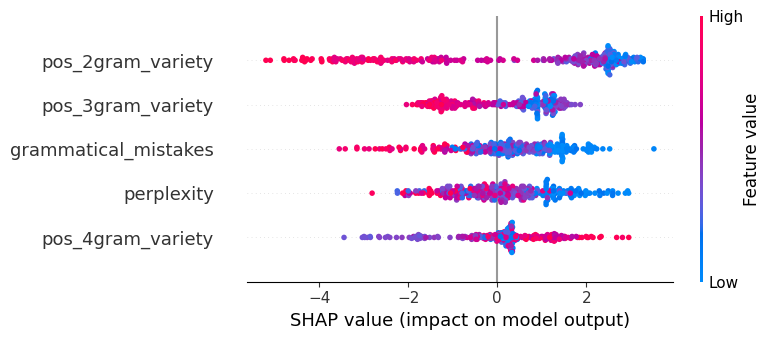

<Figure size 640x480 with 0 Axes>

In [26]:
import shap

explainer = shap.TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')

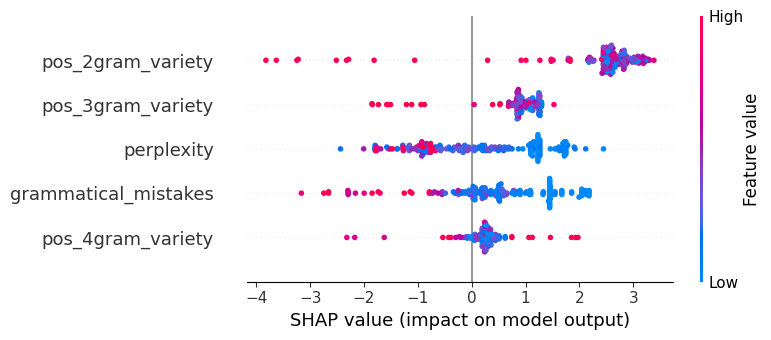

<Figure size 640x480 with 0 Axes>

In [27]:
coling_shap_values = explainer.shap_values(coling_test_data)
shap.summary_plot(coling_shap_values, coling_test_data)
plt.savefig('shap_summary_plot_coling.png', dpi=300, bbox_inches='tight')

In [28]:
import seaborn as sns

def get_top_features(model, top_n=5):
    importance_df = (
        pd.DataFrame({'Feature': model.get_booster().feature_names,
                      'Importance': model.feature_importances_})
        .sort_values(by='Importance', ascending=False)
        .head(top_n)
    )
    return importance_df


def compute_threshold(df, feature_name, label_col='label'):
    human_mean = df[df[label_col] == 0][feature_name].mean()
    ai_mean = df[df[label_col] == 1][feature_name].mean()
    threshold = (human_mean + ai_mean) / 2
    return round(threshold, 3)


def plot_feature_distribution(df, feature_name, label_col='label'):
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature_name, hue=label_col, kde=True, palette='coolwarm', bins=30)
    plt.title(f"Distribution of {feature_name} (Human=0 vs AI=1)")
    plt.xlabel(feature_name)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


def plot_shap_dependency(feature_name, shap_values, features_df):
    shap.dependence_plot(
        feature_name,
        shap_values.values,
        features_df,
        display_features=features_df,
        show=False
    )
    plt.title(f"SHAP Dependence for '{feature_name}'")
    plt.tight_layout()
    plt.show()


def deep_shap_analysis(model, X, y, top_n=5):
    # Combine into single DataFrame
    df = X.copy()
    df['label'] = y.values

    # Get SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)

    # Identify top features
    top_feats = get_top_features(model, top_n)
    print("\nTop Features by Importance:\n", top_feats, "\n")

    results = []

    for feat in top_feats['Feature']:
        print(f"🔹 Analyzing Feature: {feat}")

        threshold = compute_threshold(df, feat)
        plot_feature_distribution(df, feat)
        plot_shap_dependency(feat, shap_values, X)

        results.append({
            'Feature': feat,
            'Threshold': threshold,
            'Mean_SHAP_Impact': round(np.mean(np.abs(shap_values[:, list(X.columns).index(feat)].values)), 4)
        })

    results_df = pd.DataFrame(results)
    return results_df



Top Features by Importance:
                 Feature  Importance
1     pos_2gram_variety    0.605751
0  grammatical_mistakes    0.128504
2     pos_3gram_variety    0.097173
4            perplexity    0.086340
3     pos_4gram_variety    0.082233 

🔹 Analyzing Feature: pos_2gram_variety


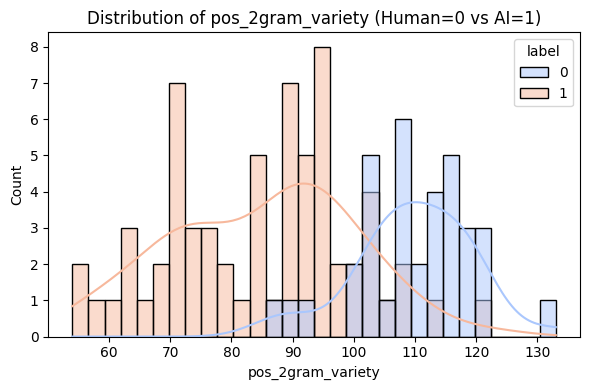

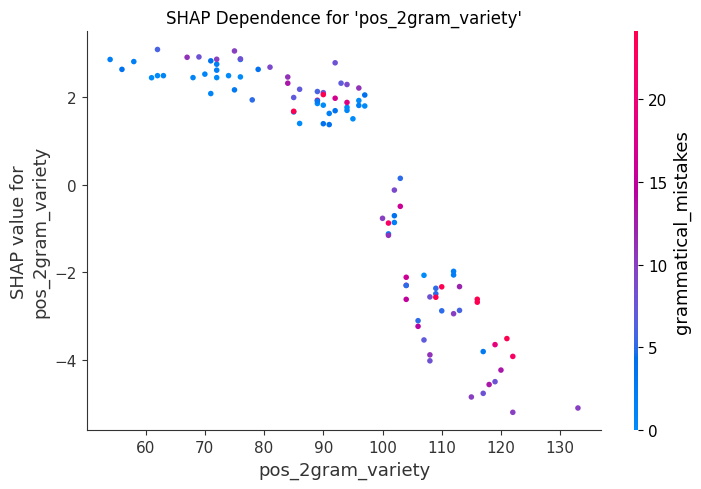

🔹 Analyzing Feature: grammatical_mistakes


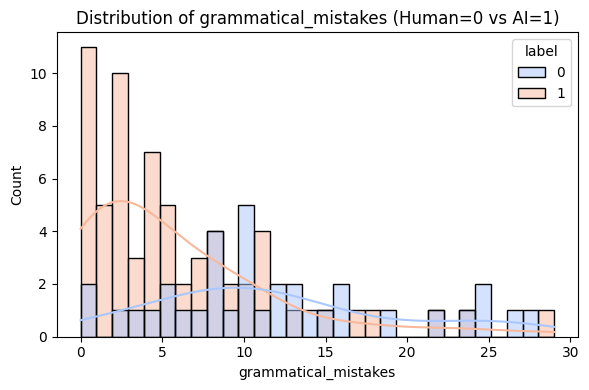

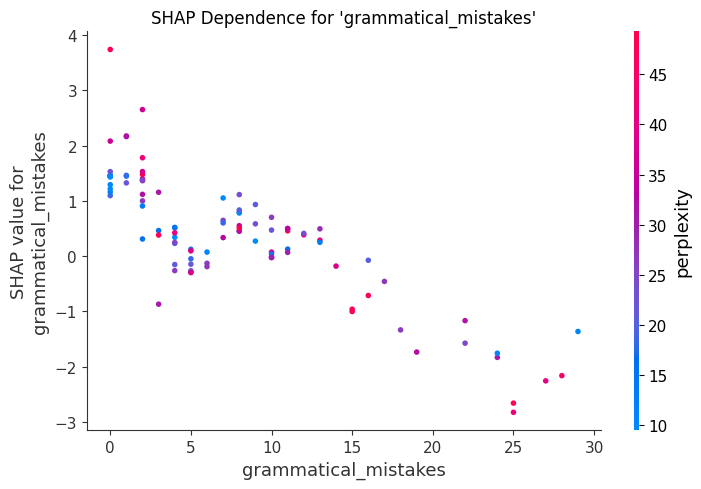

🔹 Analyzing Feature: pos_3gram_variety


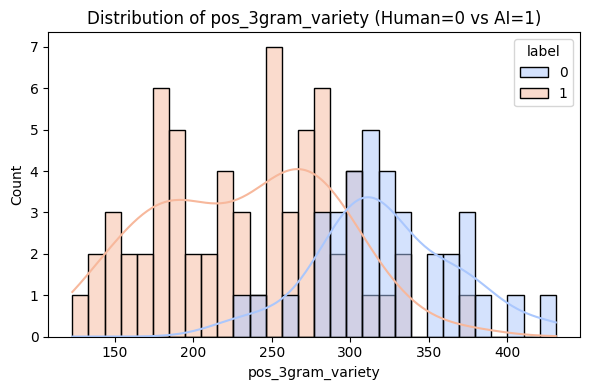

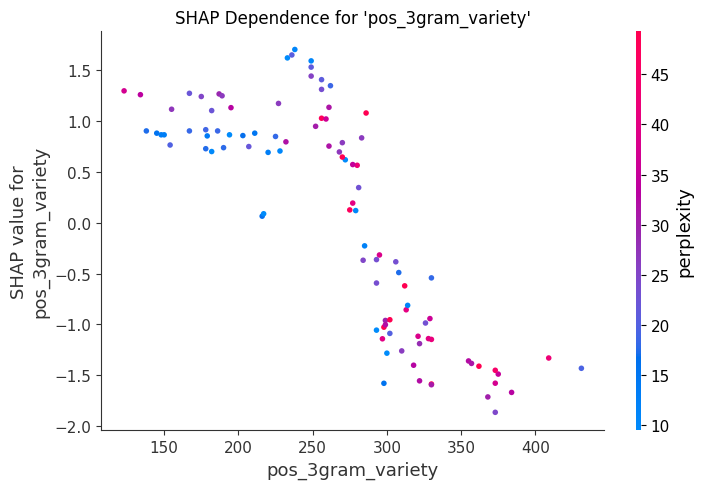

🔹 Analyzing Feature: perplexity


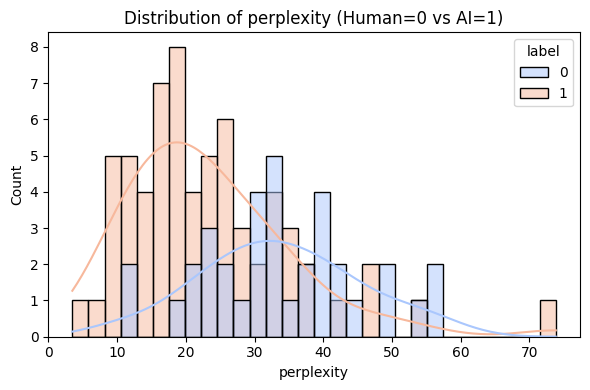

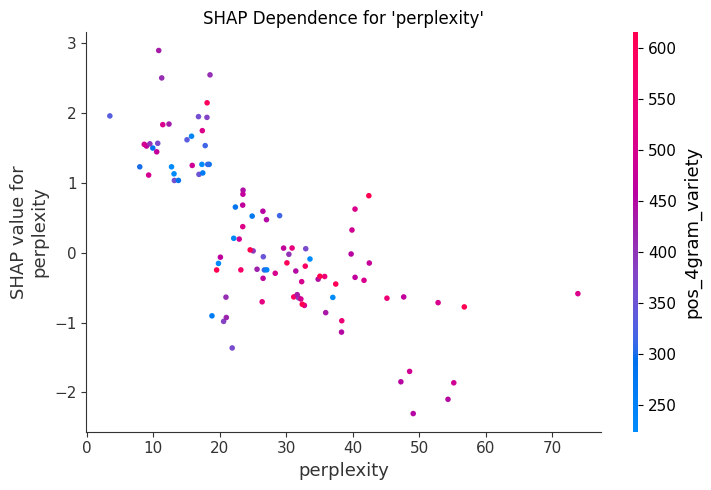

🔹 Analyzing Feature: pos_4gram_variety


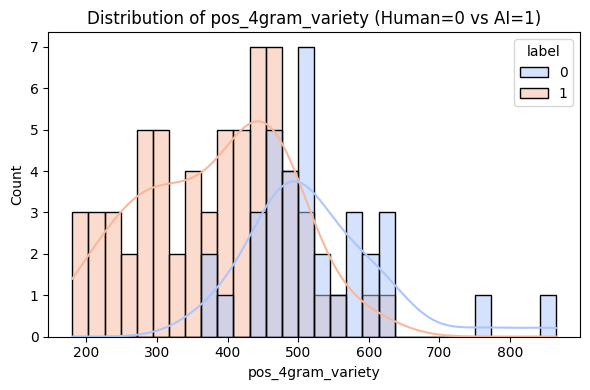

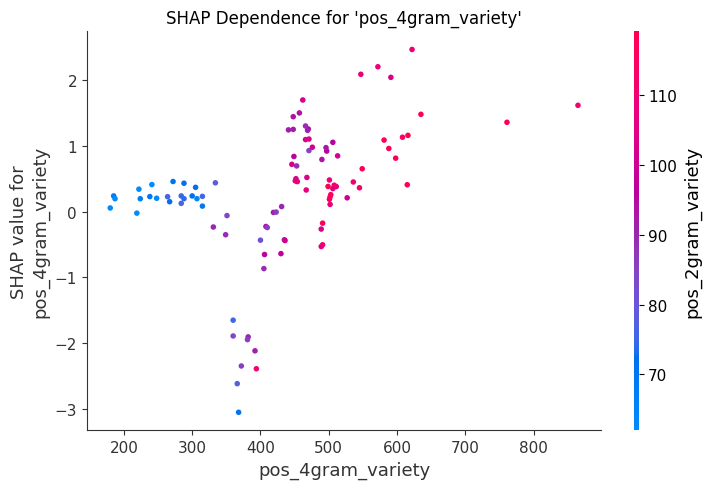


Summary of Thresholds and SHAP Effects:
                 Feature  Threshold  Mean_SHAP_Impact
0     pos_2gram_variety     97.409            2.4433
1  grammatical_mistakes      8.790            0.9026
2     pos_3gram_variety    278.101            1.0014
3            perplexity     28.519            0.8940
4     pos_4gram_variety    454.316            0.7887


In [29]:
results_df = deep_shap_analysis(models['XGB'], X_test, y_test, top_n=5)
print("\nSummary of Thresholds and SHAP Effects:\n", results_df)


Top Features by Importance:
                 Feature  Importance
1     pos_2gram_variety    0.605751
0  grammatical_mistakes    0.128504
2     pos_3gram_variety    0.097173
4            perplexity    0.086340
3     pos_4gram_variety    0.082233 

🔹 Analyzing Feature: pos_2gram_variety


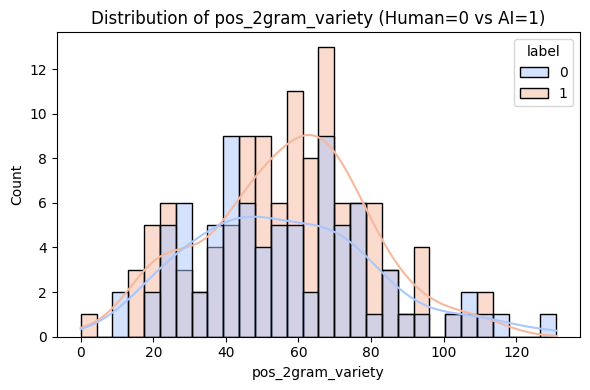

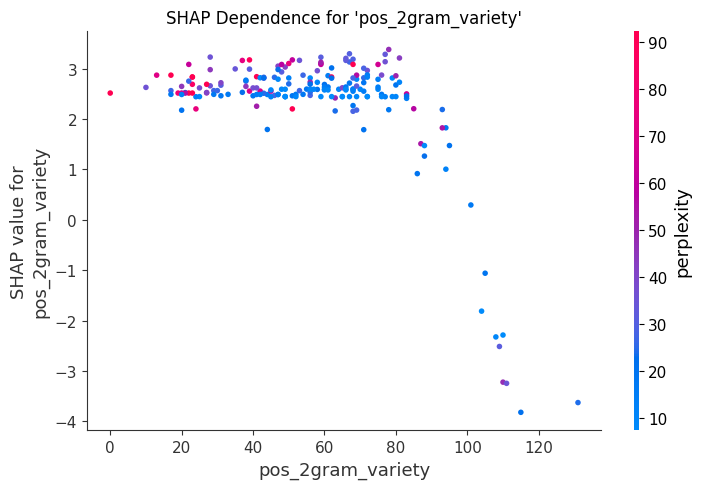

🔹 Analyzing Feature: grammatical_mistakes


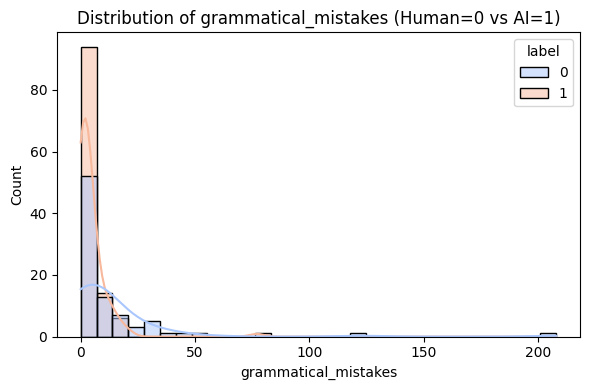

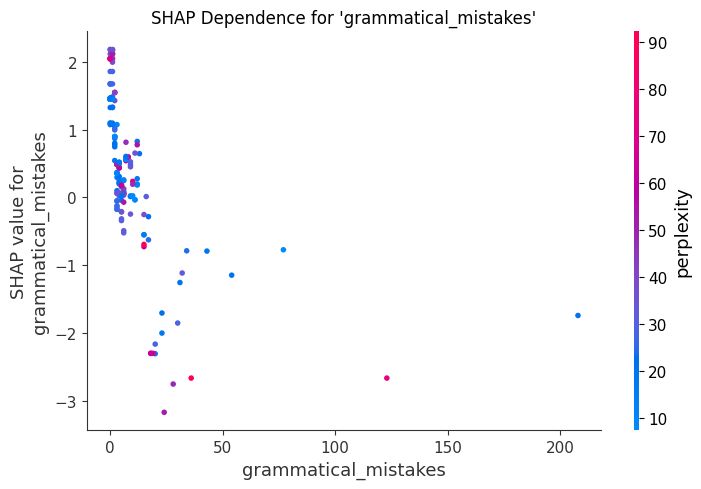

🔹 Analyzing Feature: pos_3gram_variety


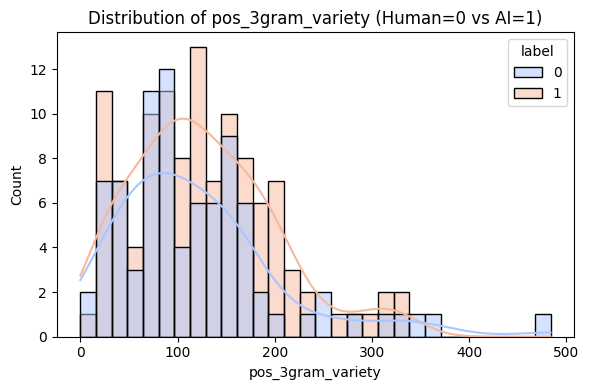

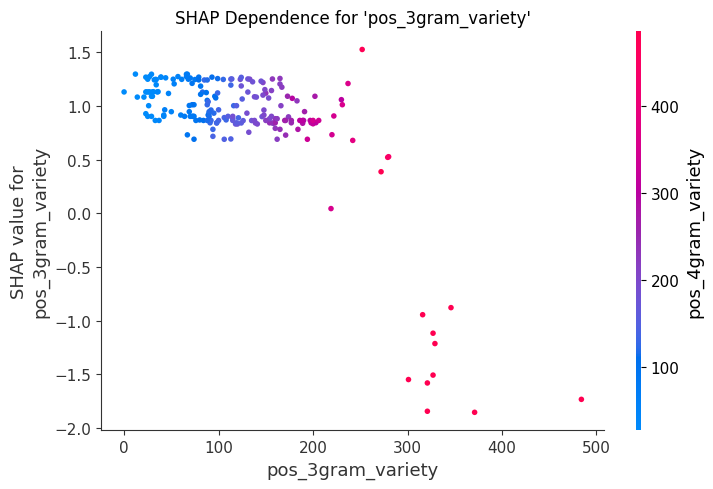

🔹 Analyzing Feature: perplexity


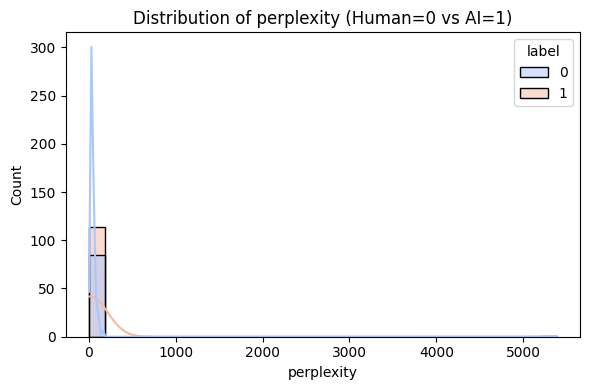

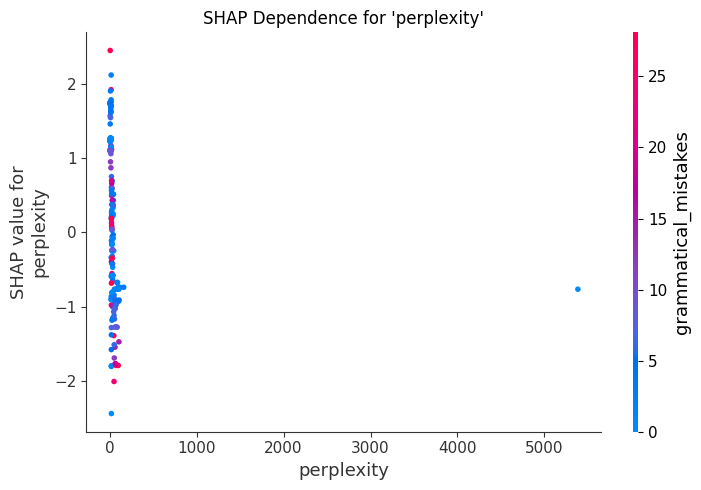

🔹 Analyzing Feature: pos_4gram_variety


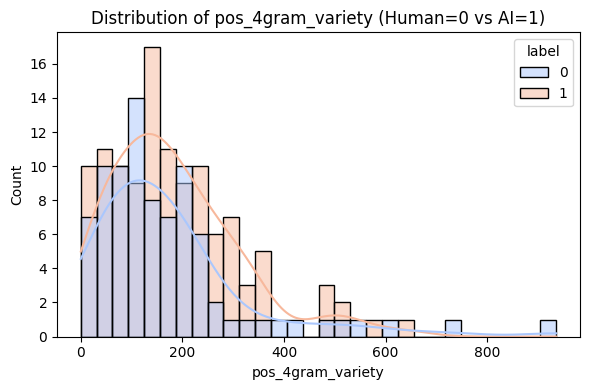

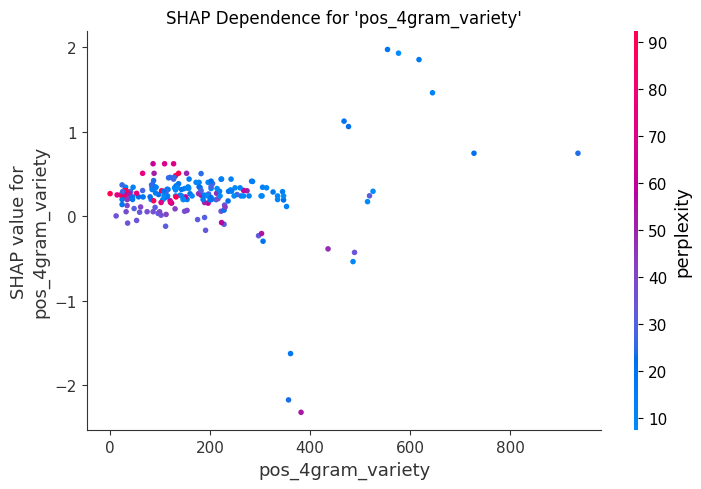


Summary of Thresholds and SHAP Effects:
                 Feature  Threshold  Mean_SHAP_Impact
0     pos_2gram_variety     56.472            2.6093
1  grammatical_mistakes      8.471            0.9609
2     pos_3gram_variety    123.342            1.0226
3            perplexity     56.741            0.9837
4     pos_4gram_variety    178.528            0.3356


In [30]:
results_df = deep_shap_analysis(models['XGB'], coling_test_data, coling_test_label, top_n=5)
print("\nSummary of Thresholds and SHAP Effects:\n", results_df)